Kaggleの **Home Credit Default Risk** コンペティションの学習および推定を行います。

[Home Credit Default Risk | Kaggle](https://www.kaggle.com/c/home-credit-default-risk)

## 【問題1】コンペティション内容の確認
コンペティションのOverviewページ読み、「Home Credit Default Risk」について以下の観点について確認してください。

- 何を学習し、何を予測するのか
    - 信用履歴の代替データを利用して、クライアントの返済能力を予測する
- どのようなファイルを作りKaggleに提出するか
    - application_test.csv　のそれぞれの　SK_ID_CURR　について、TARGET変数の確率を予測する
- 提出されたものはどういった指標値で評価されるのか
    - 予測された確率と観測されたターゲットの間の`ROC曲線(Receiver Operating Characteristic curve)`の下の部分の面積：`AUC(Area Under the Curve)`
    - AUC は0から1前の値をとり、値が1に近いほど判別力が高い<br>
    
     **(Wikipedia)**  
    ![image](https://upload.wikimedia.org/wikipedia/commons/thumb/d/de/ROC_curve.svg/1920px-ROC_curve.svg.png)

## ベースラインモデルの作成

まずは単純な方法による **ベースラインモデル**　を作成します。精度の基準となるモデルです。

精度を高くする必要はありません。エラーなく実行でき、Kaggle側に推定値を提出できることを目指します。


## 【問題2】学習と検証
データを簡単に分析、前処理し、学習、検証するまでの一連の流れを作成・実行してください。

検証にはこのコンペティションで使用される評価指標を用いるようにしてください。学習に用いる手法は指定しません。

In [1]:
import pandas as pd
pd.get_option('display.max_columns', 300)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import missingno as msno
from copy import deepcopy
# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder
# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

/Users/ikeda/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# AUC値とROC曲線を表示する
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline
def roc_evaluation(y_true, y_pred_proba):
    auc = roc_auc_score(y_true, y_pred_proba) 
    print('AUC値:{}'.format(auc))
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba, drop_intermediate=False)
    fig = plt.figure(figsize=(4, 3))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(fpr, tpr)
    ax.set_xlabel('FPR: False positive rate')
    ax.set_ylabel('TPR: True positive rate')
    plt.grid()
    plt.show()

In [3]:
DF_TRAIN = pd.read_csv('application_train.csv', index_col=0)
DF_TEST = pd.read_csv('application_test.csv', index_col=0)
display(DF_TRAIN.head())
display(DF_TEST.head())

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,Unaccompanied,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
DF_TRAIN.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307511 entries, 100002 to 456255
Columns: 121 entries, TARGET to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(40), object(16)
memory usage: 286.2+ MB


In [5]:
DF_TEST.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48744 entries, 100001 to 456250
Columns: 120 entries, NAME_CONTRACT_TYPE to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(39), object(16)
memory usage: 45.0+ MB


In [6]:
# 目的変数を切り出し、DataFrameから除外する
y_train = DF_TRAIN['TARGET'].values
DF_TRAIN.drop('TARGET', axis=1, inplace=True)

In [7]:
df_train = deepcopy(DF_TRAIN)
df_test = deepcopy(DF_TEST)

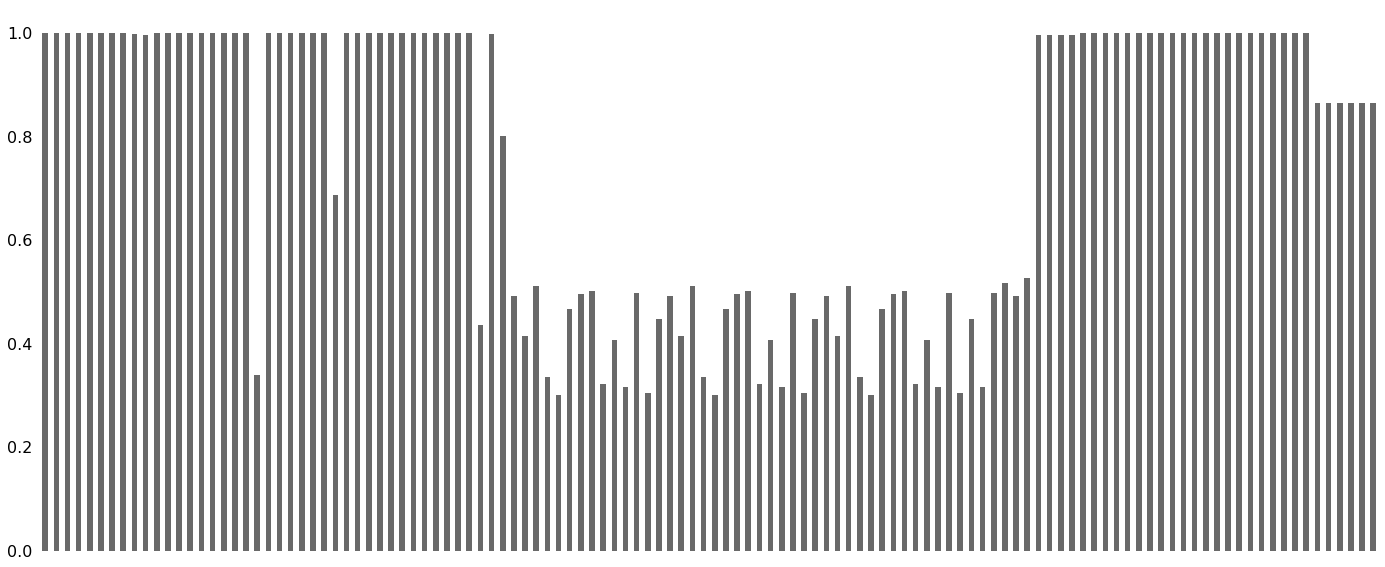

In [8]:
msno.bar(df_train)
plt.show()

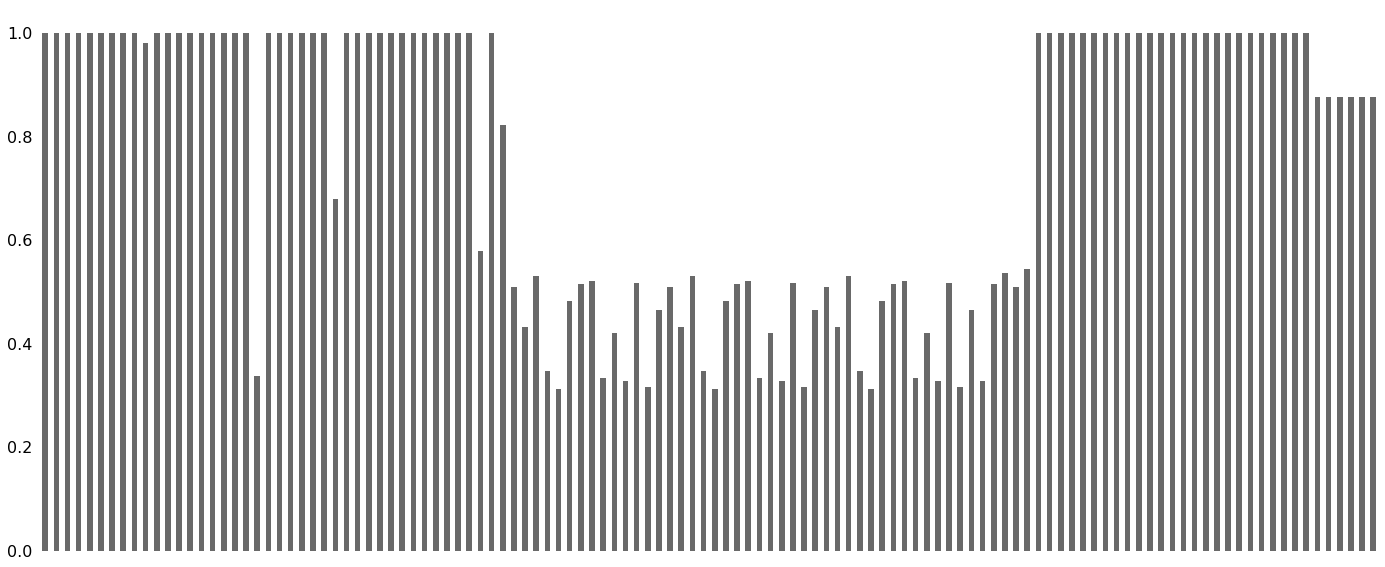

In [9]:
msno.bar(df_test)
plt.show()

In [10]:
# 'TARGET'を消去したtrainデータとtestデータ全ての列が同じ名称であることを確認
(df_train.columns == df_test.columns).all()

True

In [11]:
# trainデータ、testデータともに、以下処理
# object：DataFrameからdrop
# int, float：欠損値は平均値で置き換える
feature_lst = []
for i, df in enumerate([df_train, df_test]):
    for column in df.columns:
        if df[column].dtype == 'object':
            df.drop(column, axis=1, inplace=True)
        else:
            if df[column].isnull().any():
                df[column].fillna(df[column].mean(), inplace=True)
            if i == 0:
                feature_lst.append(column)

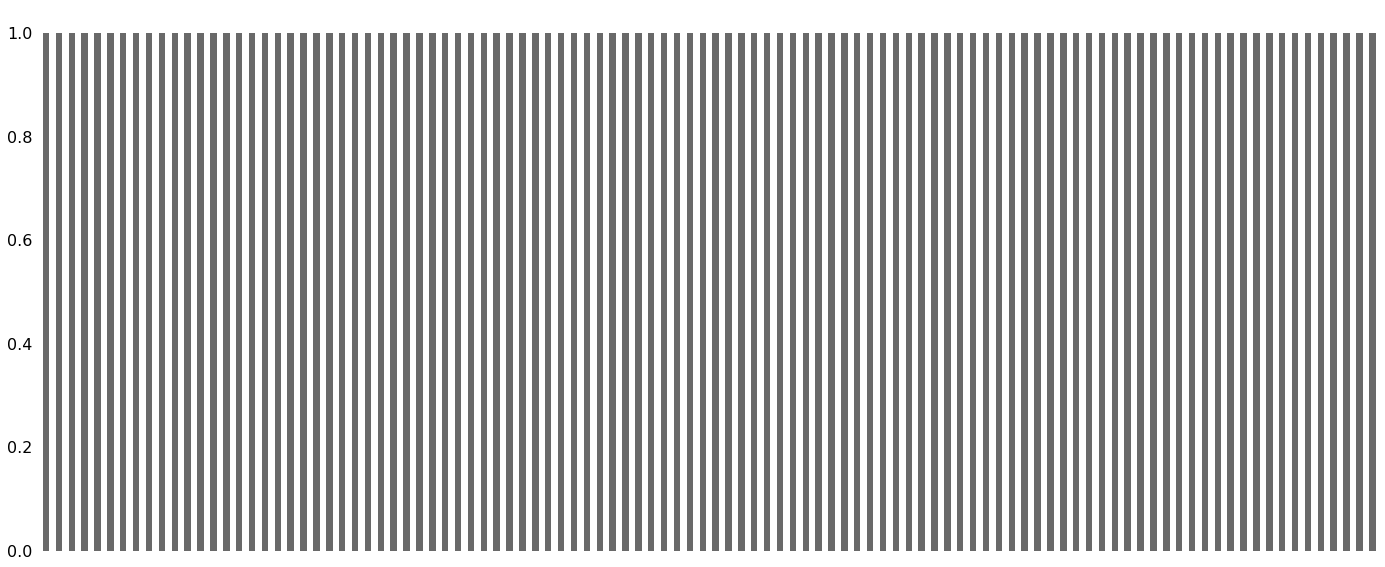

In [12]:
msno.bar(df_train)
plt.show()

In [13]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307511 entries, 100002 to 456255
Columns: 104 entries, CNT_CHILDREN to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(39)
memory usage: 246.3 MB


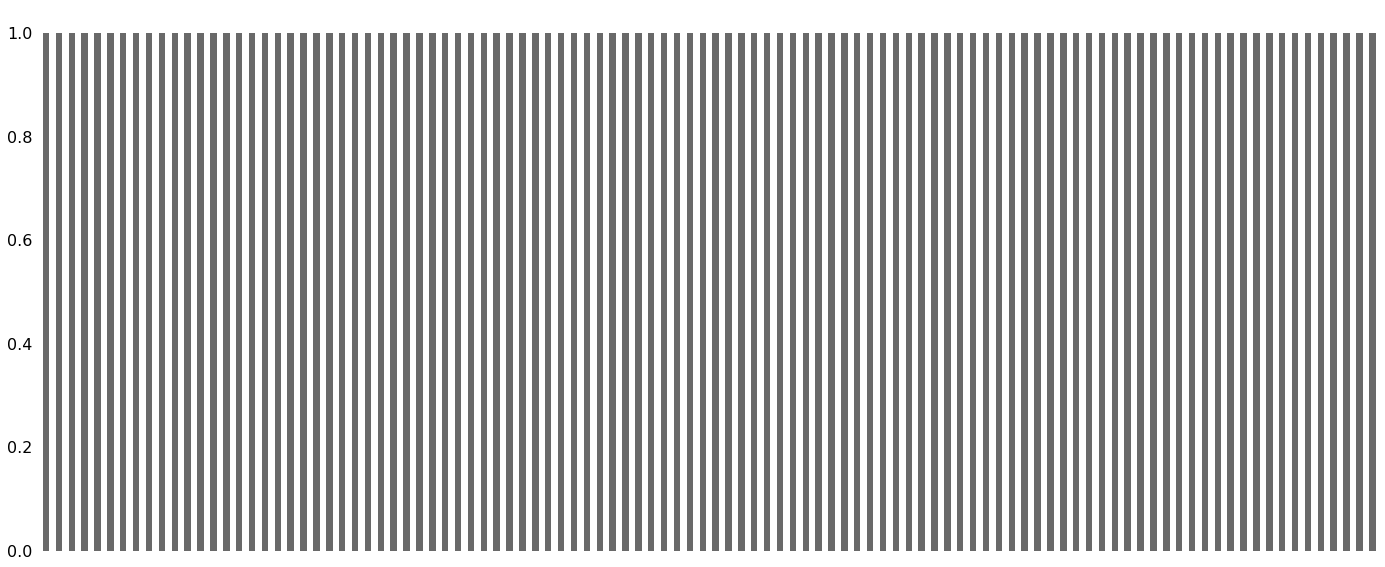

In [14]:
msno.bar(df_test)
plt.show()

In [15]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48744 entries, 100001 to 456250
Columns: 104 entries, CNT_CHILDREN to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(39)
memory usage: 39.0 MB


In [16]:
X_train = df_train.values
X_test = df_test.values

In [17]:
# X_train　を train_data　と　test_data　にわけモデルの精度をみる
from sklearn.model_selection import train_test_split
X_train_train, X_train_test, y_train_train, y_train_test = train_test_split(
    X_train, y_train, random_state=0)

In [18]:
# 標準化による前処理
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train_train)
X_train_train_trans = scaler.transform(X_train_train)
X_train_test_trans = scaler.transform(X_train_test)

In [19]:
# ランダムフォレストで学習
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=10, random_state=0)
forest.fit(X_train_train, y_train_train)
y_pred_proba = forest.predict_proba(X_train_test)[:, 1]

AUC値:0.6311118291782953


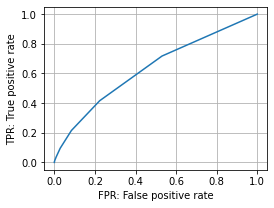

In [20]:
#　評価
roc_evaluation(y_train_test, y_pred_proba)

##### パターン1
- 欠損値の処理
    - float, intは平均値で全部埋める、objectは最頻値で埋める
- 特徴量
    　- float, intを全て採用
- 前処理
    - 標準化を行う
- モデル
    - ランダムフォレスト

## 【問題3】テストデータに対する推定
テストデータ（`application_test.csv`）に対して推定を行い、Kaggleに提出を行ってください。

正しく提出が行えていれば、精度は低くても構いません。

In [21]:
# 標準化による前処理
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_trans = scaler.transform(X_train)
X_test_trans = scaler.transform(X_test)

In [22]:
# ランダムフォレストで学習
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=10, random_state=0)
forest.fit(X_train, y_train)
y_pred_proba = forest.predict_proba(X_test)[:, 1]

In [23]:
submit_df = pd.DataFrame(y_pred_proba, index=df_test.index, columns=['TARGET'])
submit_df

,TARGET
SK_ID_CURR,
100001,0.0
100005,0.1
100013,0.0
100028,0.0
100038,0.1
...,...
456221,0.0
456222,0.0
456223,0.0


In [24]:
submit_df.to_csv('submit_file')
# Score:0.61299

## 【問題4】特徴量エンジニアリング
精度を上げるために以下のような観点で 特徴量エンジニアリング（Feature Engineering） を行ってください。

- どの特徴量を使うか
- どう前処理をするか

何をした時に検証データに対する評価指標がどのようになったかをまとめてください。最低5パターンの学習・検証を行ってください。

精度が高かったものに関してはテストデータに対しても推定を行い、Kaggleに提出を行ってください。

In [85]:
# 別のnotebook　でデータ可視化
class PDF(object):
    def __init__(self, pdf, size=(200,200)):
        self.pdf = pdf
        self.size = size
    def _repr_html_(self):
        return '<iframe src={0} width={1[0]} height={1[1]}></iframe>'.format(self.pdf, self.size)
    def _repr_latex_(self):
        return r'\includegraphics[width=1.0\textwidth]{{{0}}}'.format(self.pdf)
PDF('Week4_task_graph.pdf',size=(900,500))

In [25]:
df_train = deepcopy(DF_TRAIN)
df_test = deepcopy(DF_TEST)

In [26]:
# object　は欠損処理を行わずダミー変数に置き換える
# float, int は平均値で欠損処理
for column in df_train.columns:
    if df_train[column].dtype != 'object':
        df_train[column].fillna(df_train[column].mean(), inplace=True)
        df_test[column].fillna(df_test[column].mean(), inplace=True)
df_concat = pd.concat([df_train, df_test], axis=0)
df_concat_dummies = pd.get_dummies(df_concat, drop_first=True, dummy_na=True)

In [27]:
# df_concat_dummiesを再度df_train, df_testへ分割
# train:307511, test:48744
df_train = df_concat_dummies.iloc[:307511, :]
df_test = df_concat_dummies.iloc[307511:, :]
len(df_train) == len(DF_TRAIN), len(df_test) == len(DF_TEST)

(True, True)

In [28]:
X_train = df_train.values
X_test = df_test.values

In [29]:
# X_train　を train_data　と　test_data　にわけモデルの精度をみる
from sklearn.model_selection import train_test_split
X_train_train, X_train_test, y_train_train, y_train_test = train_test_split(
    X_train, y_train, random_state=0)

In [30]:
# 標準化による前処理
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train_train)
X_train_train_trans = scaler.transform(X_train_train)
X_train_test_trans = scaler.transform(X_train_test)

In [31]:
# ランダムフォレストで学習
from sklearn.ensemble import RandomForestClassifier
forest1 = RandomForestClassifier(n_estimators=10, random_state=0)
forest1.fit(X_train_train, y_train_train)
y_pred_proba = forest1.predict_proba(X_train_test)[:, 1]

AUC値:0.6297903899901647


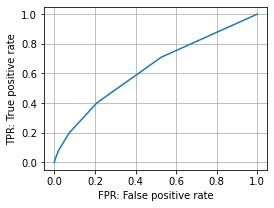

In [32]:
#　評価
roc_evaluation(y_train_test, y_pred_proba)

##### パターン2
- 欠損値の処理
    - float, intは平均値で全部埋める、objectはNanも含めてダミー変数化
- 特徴量
    - float, int, object(dummies)を全て採用
- 前処理
    - 標準化を行う
- モデル
    - ランダムフォレスト
- 考察
    - scoreに殆ど変化が見られず、精度が低いまま。特徴量の峻別を行う

#### 特徴量の重要度を確認
- 現在まで作成した２パターンを図示

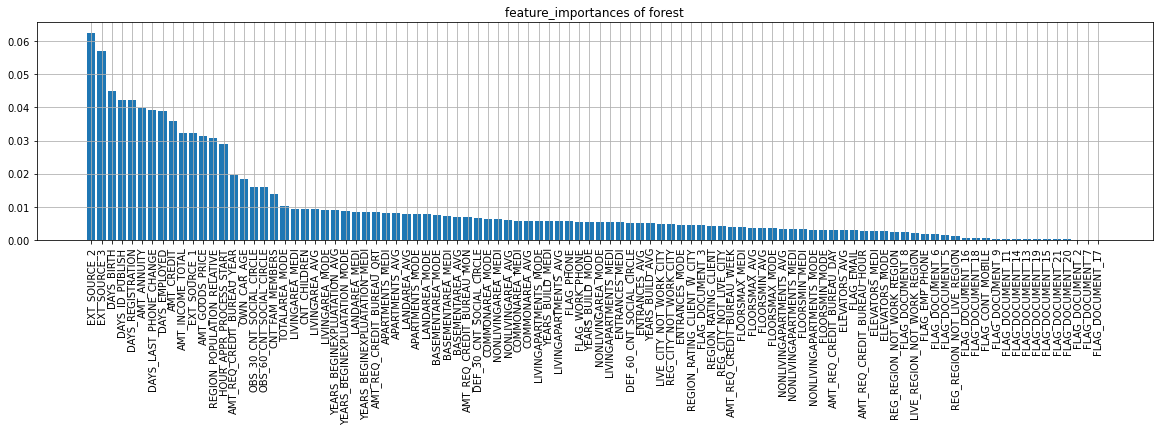

In [33]:
df_feature_importances = pd.DataFrame(forest.feature_importances_, index=feature_lst, columns=['forest']).sort_values('forest', ascending=False)
# 数が多いので数を絞る
df_for_plot = df_feature_importances.head(100)
fig = plt.figure(figsize=(20, 4))
ax = fig.add_subplot(1, 1, 1)
ax.bar(df_for_plot.index, df_for_plot['forest'])
ax.set_title('feature_importances of forest')
ax.set_xticklabels(df_for_plot.index, rotation=90)
plt.grid()

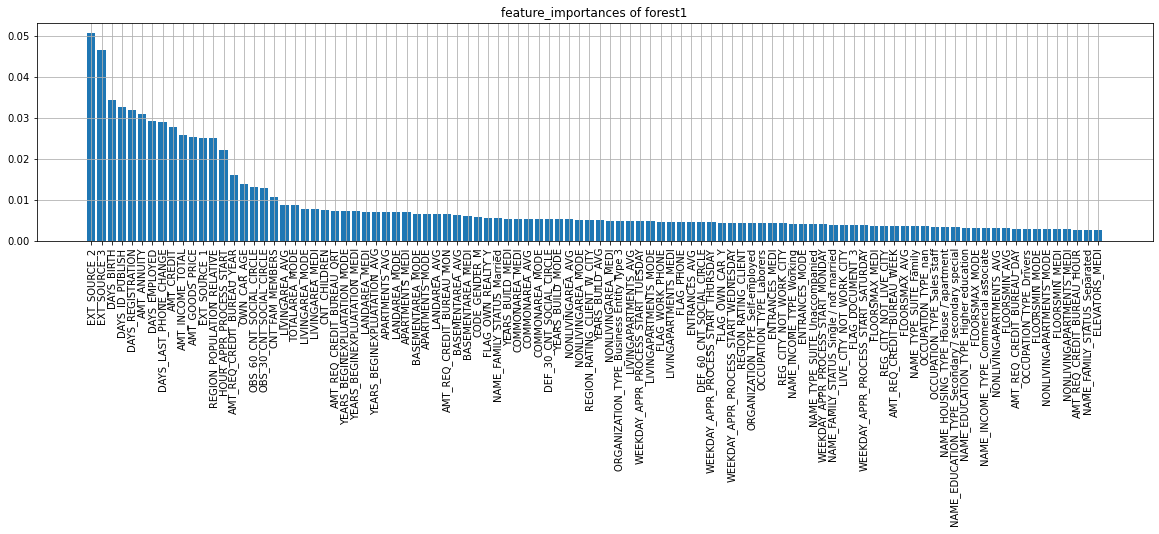

In [34]:
df_feature_importances = pd.DataFrame(forest1.feature_importances_, index=df_train.columns, columns=['forest1']).sort_values('forest1', ascending=False)
# 数が多いので数を絞る
df_for_plot = df_feature_importances.head(100)
fig = plt.figure(figsize=(20, 4))
ax = fig.add_subplot(1, 1, 1)
ax.bar(df_for_plot.index, df_for_plot['forest1'])
ax.set_title('feature_importances of forest1')
ax.set_xticklabels(df_for_plot.index, rotation=90)
plt.grid()

特徴量の重要度が高いもの：10
AUC値:0.6323979186768905


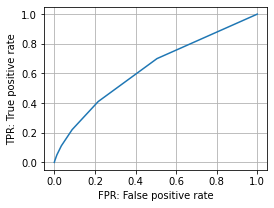

特徴量の重要度が高いもの：20
AUC値:0.6515228742039243


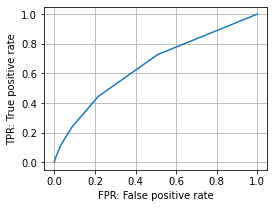

特徴量の重要度が高いもの：30
AUC値:0.6402224877429767


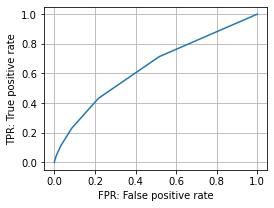

特徴量の重要度が高いもの：40
AUC値:0.6379455678886745


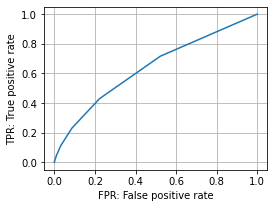

特徴量の重要度が高いもの：50
AUC値:0.6418420782475253


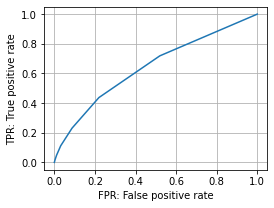

In [35]:
# forest1で重要度が高い特徴量のみで試してみる
# トップ１０、２０、３０、４０、５０
for i in range(1, 6):
    features = df_feature_importances.head(i*10).index
    X_train = df_train.loc[:, features].values
    # X_train　を train_data　と　test_data　にわけモデルの精度をみる
    from sklearn.model_selection import train_test_split
    X_train_train, X_train_test, y_train_train, y_train_test = train_test_split(X_train, y_train, random_state=0)
    # 標準化による前処理
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    scaler.fit(X_train_train)
    X_train_train_trans = scaler.transform(X_train_train)
    X_train_test_trans = scaler.transform(X_train_test)
    # ランダムフォレストで学習
    from sklearn.ensemble import RandomForestClassifier
    forest = RandomForestClassifier(n_estimators=10, random_state=0)
    forest.fit(X_train_train, y_train_train)
    y_pred_proba = forest.predict_proba(X_train_test)[:, 1]
    #　評価
    print('特徴量の重要度が高いもの：{}'.format(i*10))
    roc_evaluation(y_train_test, y_pred_proba)

##### パターン3
- 欠損値の処理
    - float, intは平均値で全部埋める、objectはNanも含めてダミー変数化
- 特徴量
    - パターン２で学習したもので特徴量が高いトップ10、２０、３０、４０、５０を選択
- 前処理
    - 標準化を行う
- モデル
    - ランダムフォレスト
- 考察
    - scoreは0.03ほど上昇した結果もあるが、大きな改善にはならず
    - Kaggleから特徴量の選択の仕方、変換のやり方を勉強して試してみる

### 参考
- [HomeCreditRisk : Extensive EDA + Baseline Model JP](https://www.kaggle.com/osciiart/homecreditrisk-extensive-eda-baseline-model-jp)

In [36]:
# カテゴリ変数を取得する関数
def _get_categorical_features(df):
    cats = [column for column in list(df.columns) if df[column].dtype == 'object']
    return cats

# カテゴリ変数をファクトライズ（整数に置換）する関数
def _factorize_categoricals(df, cats):
    for column in cats:
        df[column], _ = pd.factorize(df[column])
    return df

# カテゴリ変数のダミー変数を作成する関数
def _get_dummies(df, cats):
    for column in cats:
        df = pd.concat([df, pd.get_dummies(df[column], prefix=column)], axis=1)
    return df

In [37]:
# float, intは平均値で埋めて欠損処理
df_train = deepcopy(DF_TRAIN)
df_test = deepcopy(DF_TEST)
for column in df_train.columns:
    if df_train[column].dtype != 'object':
        df_train[column].fillna(df_train[column].mean(), inplace=True)
        df_test[column].fillna(df_test[column].mean(), inplace=True)

In [38]:
# 前処理のために　 train, testデータを結合する
df_concat = pd.concat([df_train, df_test], axis=0)

In [39]:
# カテゴリ変数を取得
data_cats = _get_categorical_features(df_concat)
# カテゴリ変数をファクトライズ（整数に置換）
df_concat_factorize = _factorize_categoricals(df_concat, data_cats)

In [40]:
# df_concat_factorizeを再度df_train, df_testへ分割
# train:307511, test:48744
df_train = df_concat_factorize.iloc[:307511, :]
df_test = df_concat_factorize.iloc[307511:, :]
len(df_train) == len(DF_TRAIN), len(df_test) == len(DF_TEST)

(True, True)

In [41]:
X_train = df_train.values
X_test = df_test.values

In [42]:
# X_train　を train_data　と　test_data　にわけモデルの精度をみる
from sklearn.model_selection import train_test_split
X_train_train, X_train_test, y_train_train, y_train_test = train_test_split(
    X_train, y_train, random_state=0)

In [43]:
# 標準化による前処理
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train_train)
X_train_train_trans = scaler.transform(X_train_train)
X_train_test_trans = scaler.transform(X_train_test)

In [44]:
# ランダムフォレストで学習
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=10, random_state=0)
forest.fit(X_train_train, y_train_train)
y_pred_proba = forest.predict_proba(X_train_test)[:, 1]

AUC値:0.6378706937603225


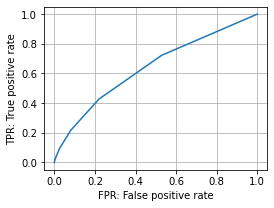

In [45]:
#　評価
roc_evaluation(y_train_test, y_pred_proba)

### 参考
- [Start Here: A Gentle Introduction](https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction)

In [46]:
df_train = deepcopy(DF_TRAIN)
df_test = deepcopy(DF_TEST)

In [47]:
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [48]:
# Missing values statistics
missing_values = missing_values_table(df_train)
missing_values.head(20)

Your selected dataframe has 120 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


In [49]:
# Number of each type of column
df_train.dtypes.value_counts()

float64    65
int64      39
object     16
dtype: int64

In [50]:
# Number of unique classes in each object column
df_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [51]:
# カテゴリ変数で２値しか持たないものはLabel-Encodingを、それ以外はOne-Hot-Encodingを行う

In [52]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0
# Iterate through the columns
for col in df_train:
    if df_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(df_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(df_train[col])
            # Transform both training and testing data
            df_train[col] = le.transform(df_train[col])
            df_test[col] = le.transform(df_test[col])
            # Keep track of how many columns were label encoded
            le_count += 1
print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


In [53]:
# one-hot encoding of categorical variables
df_train = pd.get_dummies(df_train)
df_test = pd.get_dummies(df_test)
print('Training Features shape: ', df_train.shape)
print('Testing Features shape: ', df_test.shape)

Training Features shape:  (307511, 241)
Testing Features shape:  (48744, 238)


In [54]:
# Align the training and testing data, keep only columns present in both dataframes
df_train, df_test = df_train.align(df_test, join = 'inner', axis = 1)
df_train['TARGET'] = y_train
print('Training Features shape: ', df_train.shape)
print('Testing Features shape: ', df_test.shape)

Training Features shape:  (307511, 239)
Testing Features shape:  (48744, 238)


### EDA

In [55]:
# 誕生日が負の値であったため、年齢に直してデータを見てみる
(df_train['DAYS_BIRTH'] / -365).describe()
#　合理的な水準であることを確認

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

In [56]:
# 就職日を確認
df_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

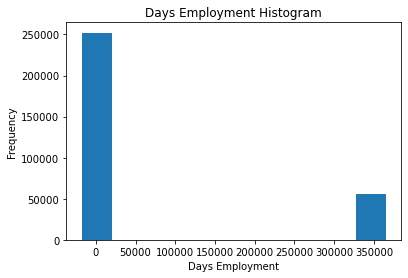

In [57]:
# maxが外れ値？
df_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');
# 最大値をとるものが一定量存在？

In [58]:
# 外れ値を含むグループとそれ以外をわけ、TARGETの割合を確認
anom = df_train[df_train['DAYS_EMPLOYED'] == 365243]
non_anom = df_train[df_train['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


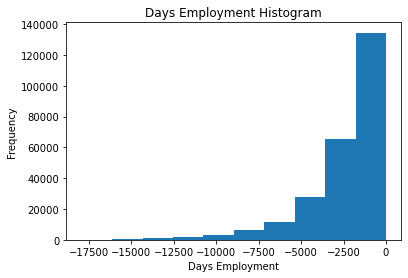

In [59]:
# 外れ値のフラグを立てて、外れ値は一旦欠損とする、分布を確認
# Create an anomalous flag column
df_train['DAYS_EMPLOYED_ANOM'] = df_train["DAYS_EMPLOYED"] == 365243
# Replace the anomalous values with nan
df_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

df_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

In [60]:
# テストデータにも同様の処理
df_test['DAYS_EMPLOYED_ANOM'] = df_test["DAYS_EMPLOYED"] == 365243
df_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

print('There are %d anomalies in the test data out of %d entries' % (df_test["DAYS_EMPLOYED_ANOM"].sum(), len(df_test)))

There are 9274 anomalies in the test data out of 48744 entries


In [61]:
# カテゴリ変数と外れ値の処理を終えたので、相関係数を確認する

# Find correlations with the target and sort
correlations = df_train.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_EMPLOYED                                        0.074958
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: float64

Most Negati

In [62]:
# DAYS_BIRTH は正の相関であるが、特徴量が負の値で記載されているため、実際は負の相関。年齢が上がるほどTARGET:1は少なくなる
# Find the correlation of the positive days since birth and target
df_train['DAYS_BIRTH'] = abs(df_train['DAYS_BIRTH'])
df_train['DAYS_BIRTH'].corr(df_train['TARGET'])

-0.07823930830982712

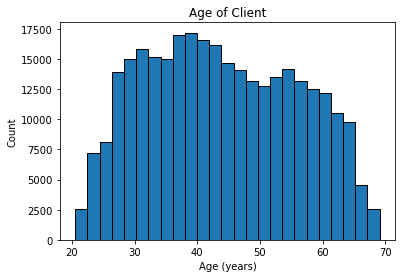

In [63]:
# Plot the distribution of ages in years
plt.hist(df_train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

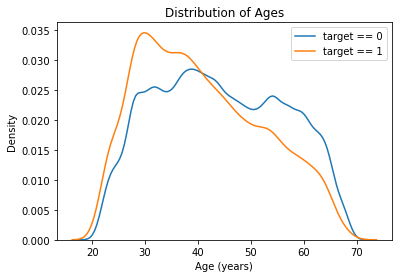

In [64]:
# TARGETとの関係をみるときは確率密度関数が役立つ
plt.figure()
# KDE plot of loans that were repaid on time
sns.kdeplot(df_train.loc[df_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')
# KDE plot of loans which were not repaid on time
sns.kdeplot(df_train.loc[df_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')
# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

In [65]:
# 5歳ごとのカテゴリにわけ、TARGETの割合をみる
# Age information into a separate dataframe
age_data = df_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365
# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
SK_ID_CURR,,,,
100002,1,9461,25.920548,"(25.0, 30.0]"
100003,0,16765,45.931507,"(45.0, 50.0]"
100004,0,19046,52.180822,"(50.0, 55.0]"
100006,0,19005,52.068493,"(50.0, 55.0]"
100007,0,19932,54.608219,"(50.0, 55.0]"
100008,0,16941,46.413699,"(45.0, 50.0]"
100009,0,13778,37.747945,"(35.0, 40.0]"
100010,0,18850,51.643836,"(50.0, 55.0]"
100011,0,20099,55.065753,"(55.0, 60.0]"


In [66]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,8532.795625,23.377522
"(25.0, 30.0]",0.111436,10155.219250,27.822518
"(30.0, 35.0]",0.102814,11854.848377,32.479037
"(35.0, 40.0]",0.089414,13707.908253,37.555913
"(40.0, 45.0]",0.078491,15497.661233,42.459346
"(45.0, 50.0]",0.074171,17323.900441,47.462741
"(50.0, 55.0]",0.066968,19196.494791,52.593136
"(55.0, 60.0]",0.055314,20984.262742,57.491131
"(60.0, 65.0]",0.052737,22780.547460,62.412459


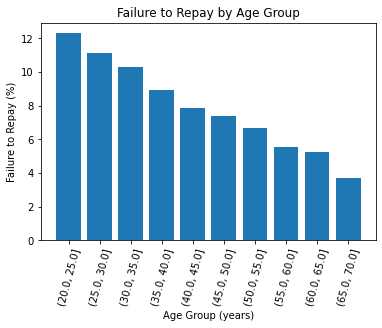

In [67]:
# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

In [68]:
# 負の相関が高く出ているEXT_SOURCE のデータを見てみる

# Extract the EXT_SOURCE variables and show correlations
ext_data = df_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.155317,-0.160472,-0.178919,-0.078239
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186846,0.600610
EXT_SOURCE_2,-0.160472,0.213982,1.000000,0.109167,0.091996
EXT_SOURCE_3,-0.178919,0.186846,0.109167,1.000000,0.205478
DAYS_BIRTH,-0.078239,0.600610,0.091996,0.205478,1.000000


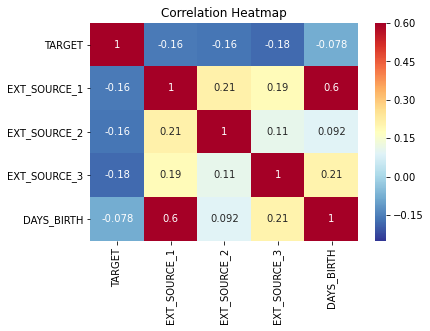

In [69]:
# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

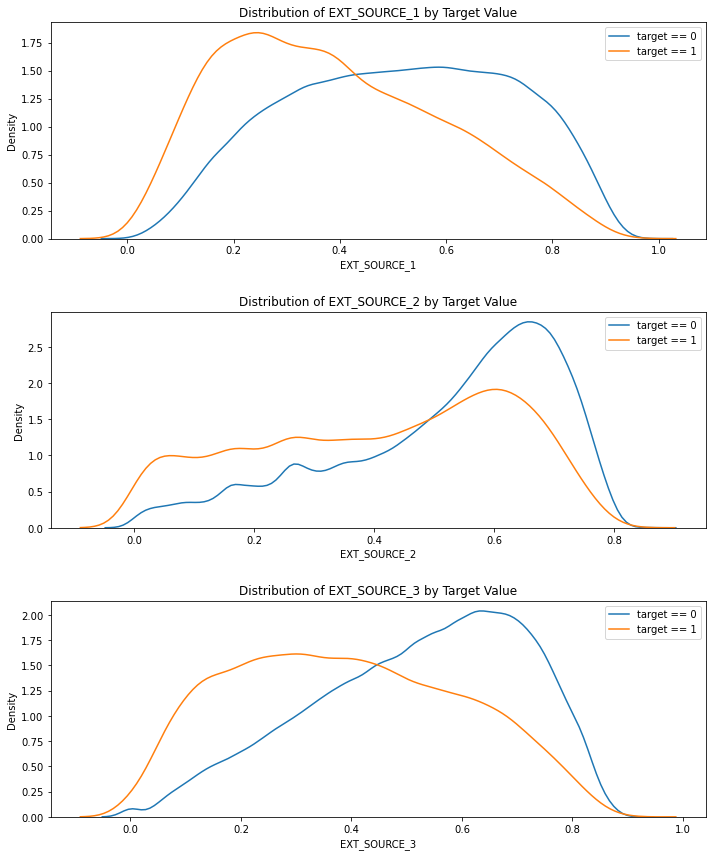

In [70]:
# それぞれの分布を確認
plt.figure(figsize = (10, 12))
# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(df_train.loc[df_train['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(df_train.loc[df_train['TARGET'] == 1, source], label = 'target == 1')
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
plt.tight_layout(h_pad = 2.5)

### Polynomical features

In [71]:
# 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'の４変数
poly_features = df_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]
poly_features_test = df_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

# imputer for handling missing values
from sklearn.impute import SimpleImputer
impute = SimpleImputer(strategy = 'median')

poly_target = poly_features['TARGET']

poly_features = poly_features.drop(columns = ['TARGET'])

# Need to impute missing values
poly_features = impute.fit_transform(poly_features)
poly_features_test = impute.transform(poly_features_test)

from sklearn.preprocessing import PolynomialFeatures
                                  
# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree = 3)

In [72]:
# Train the polynomial features
poly_transformer.fit(poly_features)
# Transform the features
poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)
print('Polynomial Features shape: ', poly_features.shape)

Polynomial Features shape:  (307511, 35)


In [73]:
poly_transformer.get_feature_names(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])

['1',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_BIRTH',
 'EXT_SOURCE_1^2',
 'EXT_SOURCE_1 EXT_SOURCE_2',
 'EXT_SOURCE_1 EXT_SOURCE_3',
 'EXT_SOURCE_1 DAYS_BIRTH',
 'EXT_SOURCE_2^2',
 'EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_2 DAYS_BIRTH',
 'EXT_SOURCE_3^2',
 'EXT_SOURCE_3 DAYS_BIRTH',
 'DAYS_BIRTH^2',
 'EXT_SOURCE_1^3',
 'EXT_SOURCE_1^2 EXT_SOURCE_2',
 'EXT_SOURCE_1^2 EXT_SOURCE_3',
 'EXT_SOURCE_1^2 DAYS_BIRTH',
 'EXT_SOURCE_1 EXT_SOURCE_2^2',
 'EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_1 EXT_SOURCE_2 DAYS_BIRTH',
 'EXT_SOURCE_1 EXT_SOURCE_3^2',
 'EXT_SOURCE_1 EXT_SOURCE_3 DAYS_BIRTH',
 'EXT_SOURCE_1 DAYS_BIRTH^2',
 'EXT_SOURCE_2^3',
 'EXT_SOURCE_2^2 EXT_SOURCE_3',
 'EXT_SOURCE_2^2 DAYS_BIRTH',
 'EXT_SOURCE_2 EXT_SOURCE_3^2',
 'EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH',
 'EXT_SOURCE_2 DAYS_BIRTH^2',
 'EXT_SOURCE_3^3',
 'EXT_SOURCE_3^2 DAYS_BIRTH',
 'EXT_SOURCE_3 DAYS_BIRTH^2',
 'DAYS_BIRTH^3']

In [74]:
# Create a dataframe of the features 
poly_features = pd.DataFrame(poly_features, 
                             columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                           'EXT_SOURCE_3', 'DAYS_BIRTH']))
# Add in the target
poly_features['TARGET'] = poly_target.values

# Find the correlations with the target
poly_corrs = poly_features.corr()['TARGET'].sort_values()

# Display most negative and most positive
print(poly_corrs.head(10))
print(poly_corrs.tail(5))

EXT_SOURCE_2 EXT_SOURCE_3                -0.193939
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.189605
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH     -0.181283
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.176428
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.172282
EXT_SOURCE_1 EXT_SOURCE_2                -0.166625
EXT_SOURCE_1 EXT_SOURCE_3                -0.164065
EXT_SOURCE_2                             -0.160295
EXT_SOURCE_2 DAYS_BIRTH                  -0.156873
EXT_SOURCE_1 EXT_SOURCE_2^2              -0.156867
Name: TARGET, dtype: float64
DAYS_BIRTH     -0.078239
DAYS_BIRTH^2   -0.076672
DAYS_BIRTH^3   -0.074273
TARGET          1.000000
1                    NaN
Name: TARGET, dtype: float64


In [75]:
# 当初より相関係数が上昇しているものもある　　train, testデータに加えてみる

# Put test features into dataframe
poly_features_test = pd.DataFrame(poly_features_test, 
                                  columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                                'EXT_SOURCE_3', 'DAYS_BIRTH']))
# Merge polynomial features into training dataframe
poly_features['SK_ID_CURR'] = df_train.index
df_train_poly = df_train.merge(poly_features, on = 'SK_ID_CURR', how = 'left')

# Merge polnomial features into testing dataframe
poly_features_test['SK_ID_CURR'] = df_test.index
df_test_poly = df_test.merge(poly_features_test, on = 'SK_ID_CURR', how = 'left')

# Align the dataframes
df_train_poly, df_test_poly = df_train_poly.align(df_test_poly, join = 'inner', axis = 1)

# Print out the new shapes
print('Training data with polynomial features shape: ', df_train_poly.shape)
print('Testing data with polynomial features shape:  ', df_test_poly.shape)

Training data with polynomial features shape:  (307511, 275)
Testing data with polynomial features shape:   (48744, 275)


### Domain Knowledge features
- 以下4つの特徴量を新たに作成 [参考](https://www.kaggle.com/jsaguiar/lightgbm-with-simple-features)
    - CREDIT_INCOME_PERCENT: the percentage of the credit amount relative to a client's income
    - ANNUITY_INCOME_PERCENT: the percentage of the loan annuity relative to a client's income
    - CREDIT_TERM: the length of the payment in months (since the annuity is the monthly amount due
    - DAYS_EMPLOYED_PERCENT: the percentage of the days employed relative to the client's age

In [76]:
df_train_domain = df_train.copy()
df_test_domain = df_test.copy()

df_train_domain['CREDIT_INCOME_PERCENT'] = df_train_domain['AMT_CREDIT'] / df_train_domain['AMT_INCOME_TOTAL']
df_train_domain['ANNUITY_INCOME_PERCENT'] = df_train_domain['AMT_ANNUITY'] / df_train_domain['AMT_INCOME_TOTAL']
df_train_domain['CREDIT_TERM'] = df_train_domain['AMT_ANNUITY'] / df_train_domain['AMT_CREDIT']
df_train_domain['DAYS_EMPLOYED_PERCENT'] = df_train_domain['DAYS_EMPLOYED'] / df_train_domain['DAYS_BIRTH']

df_test_domain['CREDIT_INCOME_PERCENT'] = df_test_domain['AMT_CREDIT'] / df_test_domain['AMT_INCOME_TOTAL']
df_test_domain['ANNUITY_INCOME_PERCENT'] = df_test_domain['AMT_ANNUITY'] / df_test_domain['AMT_INCOME_TOTAL']
df_test_domain['CREDIT_TERM'] = df_test_domain['AMT_ANNUITY'] / df_test_domain['AMT_CREDIT']
df_test_domain['DAYS_EMPLOYED_PERCENT'] = df_test_domain['DAYS_EMPLOYED'] / df_test_domain['DAYS_BIRTH']

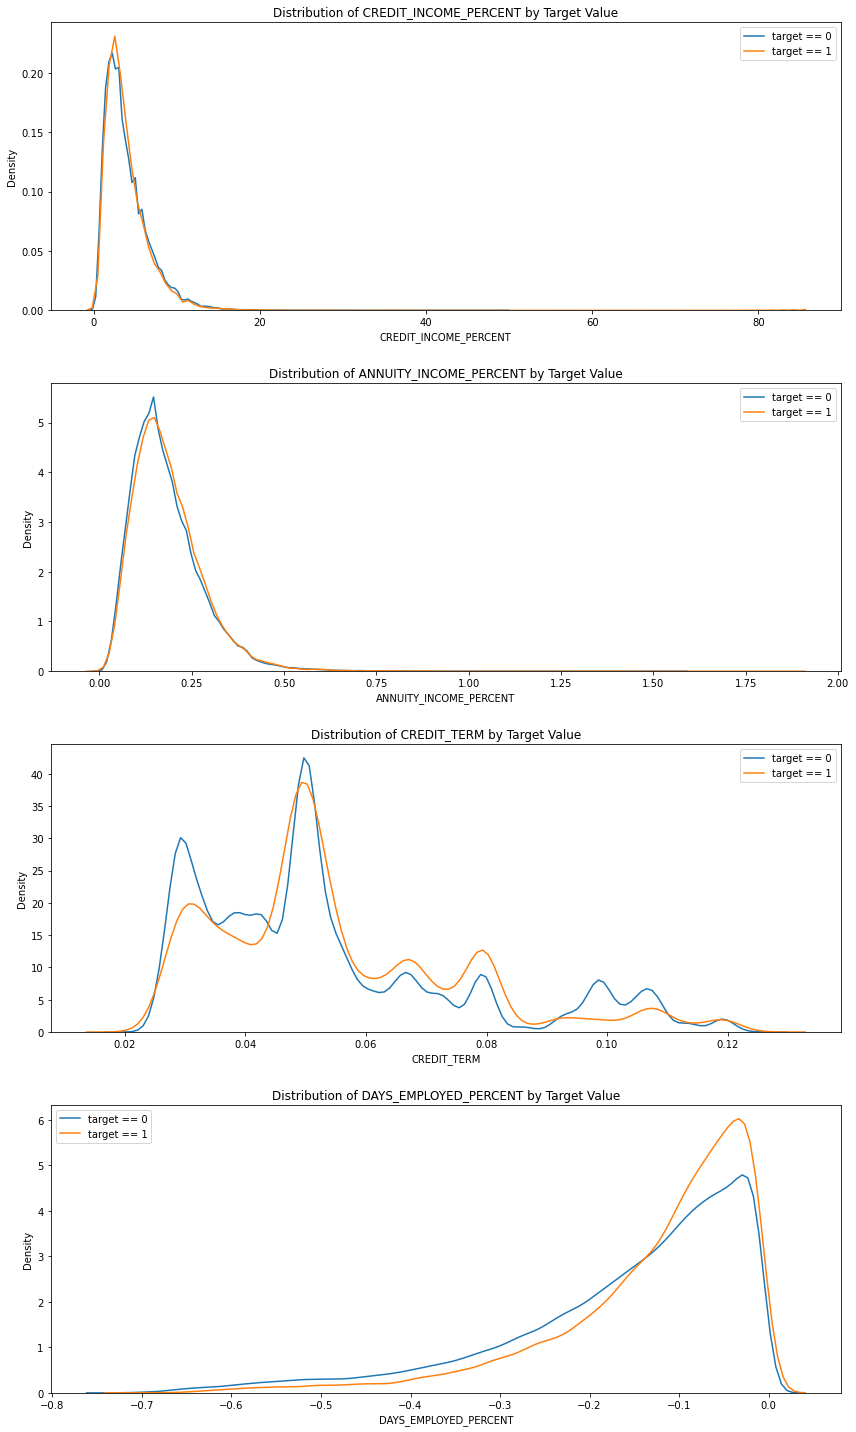

In [77]:
plt.figure(figsize = (12, 20))
# iterate through the new features
for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']):    
    # create a new subplot for each source
    plt.subplot(4, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(df_train_domain.loc[df_train_domain['TARGET'] == 0, feature], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(df_train_domain.loc[df_train_domain['TARGET'] == 1, feature], label = 'target == 1')
    # Label the plots
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Density');
plt.tight_layout(h_pad = 2.5)
# 役立つ特徴量かは現時点では不明確、試してみる

### Logistic Regression Implementation

In [78]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer 

# Drop the target from the training data
if 'TARGET' in df_train:
    train = df_train.drop(columns = ['TARGET'])
else:
    train = df_train.copy()
# Copy of the testing data
test = df_test.copy()

# カテゴリ変数で２値のものは0,1に置き換え、それ以外はダミー変数化済
# Feature names
features = list(train.columns)

# データ分割
X_train_train, X_train_test, y_train_train, y_train_test = train_test_split(
    train, y_train, random_state=0)

#　欠損値は中央値で埋める　　Median imputation of missing values
imputer = SimpleImputer(strategy = 'median')

# 0-1の間の数値に変換　　Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data
imputer.fit(X_train_train)

# Transform both training and testing data
train = imputer.transform(X_train_train)
test = imputer.transform(X_train_test)

# Repeat with the scaler
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

print('Training data shape: ', train.shape, y_train_train.shape)
print('Testing data shape: ', test.shape, y_train_test.shape)

Training data shape:  (230633, 239) (230633,)
Testing data shape:  (76878, 239) (76878,)


In [79]:
from sklearn.linear_model import LogisticRegression

# Make the model with the specified regularization parameter
log_reg = LogisticRegression(C = 0.0001)

# Train on the training data
log_reg.fit(train, y_train_train)

# Make predictions
# Make sure to select the second column only
log_reg_pred = log_reg.predict_proba(test)[:, 1]

AUC値:0.6850409736682397


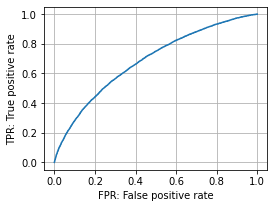

In [80]:
#　評価
roc_evaluation(y_train_test, log_reg_pred)

##### パターン3
- カテゴリ変数の処理
    - 二値変数は　０、１へ、その他はダミー変数化
- 欠損値の処理
    - 中央値で埋める
- 特徴量
    - 全て採用
- 前処理
    - 全ての変数について0-1の数値に変換
- モデル
    - ロジスティック回帰
- 考察
    - カテゴリ変数の処理をパターン２までより丁寧に行えていることでスコアが上昇したものと想定
    - ランダムフォレストで行ってみる

In [81]:
from sklearn.ensemble import RandomForestClassifier

# Make the model with the specified regularization parameter
forest = RandomForestClassifier(n_estimators=100, random_state=50)

# Train on the training data
forest.fit(train, y_train_train)

# Make predictions
# Make sure to select the second column only
forest_pred = forest.predict_proba(test)[:, 1]

AUC値:0.7146553578522373


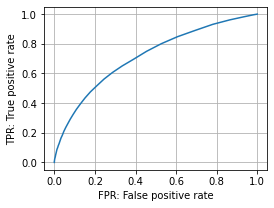

In [82]:
#　評価
roc_evaluation(y_train_test, forest_pred)

##### パターン4
- カテゴリ変数の処理
    - 二値変数は　０、１へ、その他はダミー変数化
- 欠損値の処理
    - 中央値で埋める
- 特徴量
    - 全て採用
- 前処理
    - 全ての変数について0-1の数値に変換
- モデル
    - ランダムフォレスト
- 考察
    - ロジスティクス回帰よりスコアは改善
    - 特徴量エンジニアリングをして試してみる（Polynomial Featuresを使う）

AUC値:0.7121986848904276


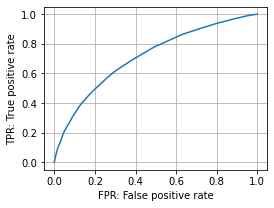

In [83]:
#  Polynomial Features
poly_features_names = list(df_train_poly.columns)

# データ分割
X_train_train, X_train_test, y_train_train, y_train_test = train_test_split(
    df_train_poly, y_train, random_state=0)

# Impute the polynomial features
imputer = SimpleImputer(strategy = 'median')

poly_features = imputer.fit_transform(X_train_train)
poly_features_test = imputer.transform(X_train_test)

# Scale the polynomial features
scaler = MinMaxScaler(feature_range = (0, 1))

poly_features = scaler.fit_transform(poly_features)
poly_features_test = scaler.transform(poly_features_test)

# RandomForest　で学習
random_forest_poly = RandomForestClassifier(n_estimators = 100, random_state = 50)
random_forest_poly.fit(poly_features, y_train_train)

# Make predictions
# Make sure to select the second column only
forest_poly_pred = random_forest_poly.predict_proba(poly_features_test)[:, 1]
#　評価
roc_evaluation(y_train_test, forest_poly_pred)

##### パターン5
- カテゴリ変数の処理
    - 二値変数は　０、１へ、その他はダミー変数化
- 特徴量
    - TARGETと相関性の高かった EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET'の４変数について、次元3でPolytical featuresを新たに作成した
- 欠損値の処理
    - 中央値で埋める
- 前処理
    - 全ての変数について0-1の数値に変換
- モデル
    - ランダムフォレスト
- 考察
    - 結果に大きな変化はない、特徴量エンジニアリングをする前と大きく変わらない
    - Domain Featuresを試してみる

In [84]:
df_train_domain = df_train_domain.drop(columns = 'TARGET')
domain_features_names = list(df_train_domain.columns)

# データ分割
X_train_train, X_train_test, y_train_train, y_train_test = train_test_split(
    df_train_domain, y_train, random_state=0)

# Impute the polynomial features
imputer = SimpleImputer(strategy = 'median')

domain_features = imputer.fit_transform(X_train_train)
domain_features_test = imputer.transform(X_train_test)

# Scale the polynomial features
scaler = MinMaxScaler(feature_range = (0, 1))

domain_features = scaler.fit_transform(domain_features)
domain_features_test = scaler.transform(domain_features_test)

AUC値:0.7168820786657424


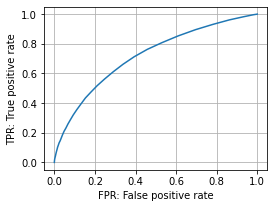

In [86]:
# RandomForest　で学習
random_forest_domain = RandomForestClassifier(n_estimators = 100, random_state = 50)
random_forest_domain.fit(domain_features, y_train_train)

# Make predictions
# Make sure to select the second column only
forest_domain_pred = random_forest_domain.predict_proba(domain_features_test)[:, 1]
#　評価
roc_evaluation(y_train_test, forest_domain_pred)

##### パターン6
- カテゴリ変数の処理
    - 二値変数は　０、１へ、その他はダミー変数化
- 特徴量
    - 他の記事を参考にドメイン知識による特徴量の変更を行った
- 欠損値の処理
    - 中央値で埋める
- 前処理
    - 全ての変数について0-1の数値に変換
- モデル
    - ランダムフォレスト
- 考察
    - 結果に大きな変化はない
    - それぞれのfeature_importances_を確認する

In [91]:
# feature_importances_　をそれぞれ計算
forest_feature_importances = pd.DataFrame(forest.feature_importances_, index=features, columns=['forest']).sort_values('forest')
forest_poly_feature_importances = pd.DataFrame(random_forest_poly.feature_importances_, index=poly_features_names, columns=['forest_poly']).sort_values('forest_poly')
forest_domain_feature_importances = pd.DataFrame(random_forest_domain.feature_importances_, index=domain_features_names, columns=['forest_domain']).sort_values('forest_domain')

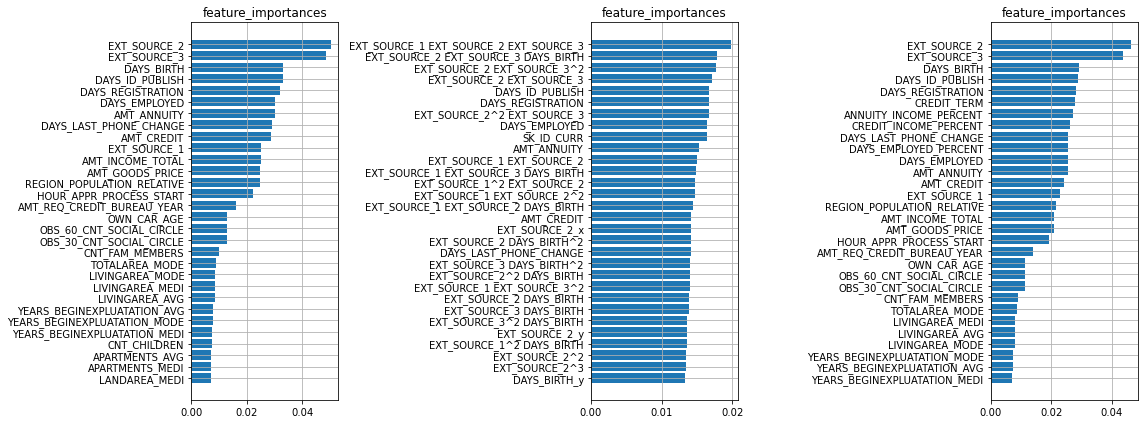

In [103]:
# トップ30をそれぞれ表示
importances_lst = [forest_feature_importances, forest_poly_feature_importances, forest_domain_feature_importances]
fig = plt.figure(figsize=(16, 6))
for i, importances in enumerate(importances_lst, 1):
    df_for_plot = importances.tail(30)
    ax = fig.add_subplot(1, 3, i)
    ax.barh(df_for_plot.index, df_for_plot.iloc[:, 0])
    ax.set_title('feature_importances')
    plt.grid()
fig.tight_layout()
plt.show()

特徴量：10個の場合
AUC値:0.7057147101537558


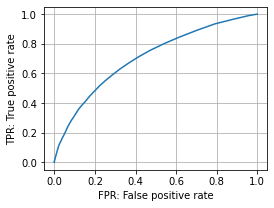

特徴量：20個の場合
AUC値:0.714170335480788


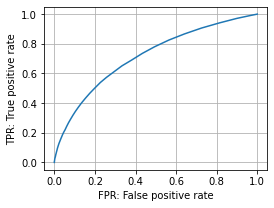

特徴量：30個の場合
AUC値:0.7086091531234187


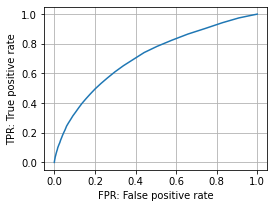

In [104]:
for i in range(1, 4):
    features = list(forest_feature_importances.tail(i*10).index)
    # データ分割
    X_train_train, X_train_test, y_train_train, y_train_test = train_test_split(df_train.loc[:, features], y_train, random_state=0)
    #　欠損値は中央値で埋める　　Median imputation of missing values
    imputer = SimpleImputer(strategy = 'median')
    # 0-1の間の数値に変換　　Scale each feature to 0-1
    scaler = MinMaxScaler(feature_range = (0, 1))
    # Fit on the training data
    imputer.fit(X_train_train)
    # Transform both training and testing data
    train = imputer.transform(X_train_train)
    test = imputer.transform(X_train_test)
    # Repeat with the scaler
    scaler.fit(train)
    train = scaler.transform(train)
    test = scaler.transform(test)
    from sklearn.ensemble import RandomForestClassifier
    # Make the model with the specified regularization parameter
    forest = RandomForestClassifier(n_estimators=100, random_state=50)
    # Train on the training data
    forest.fit(train, y_train_train)
    # Make predictions
    # Make sure to select the second column only
    forest_pred = forest.predict_proba(test)[:, 1]
    #　評価
    print('特徴量：{}個の場合'.format(i*10))
    roc_evaluation(y_train_test, forest_pred)

特徴量：10個の場合
AUC値:0.6968795456134231


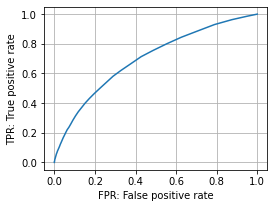

特徴量：20個の場合
AUC値:0.6954686705395181


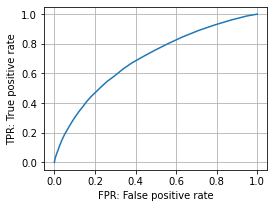

特徴量：30個の場合
AUC値:0.6950269461163742


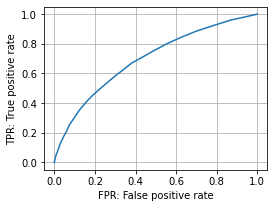

In [105]:
for i in range(1, 4):
    features = list(forest_poly_feature_importances.tail(i*10).index)
    # データ分割
    X_train_train, X_train_test, y_train_train, y_train_test = train_test_split(df_train_poly.loc[:, features], y_train, random_state=0)
    #　欠損値は中央値で埋める　　Median imputation of missing values
    imputer = SimpleImputer(strategy = 'median')
    # 0-1の間の数値に変換　　Scale each feature to 0-1
    scaler = MinMaxScaler(feature_range = (0, 1))
    # Fit on the training data
    imputer.fit(X_train_train)
    # Transform both training and testing data
    train = imputer.transform(X_train_train)
    test = imputer.transform(X_train_test)
    # Repeat with the scaler
    scaler.fit(train)
    train = scaler.transform(train)
    test = scaler.transform(test)
    from sklearn.ensemble import RandomForestClassifier
    # Make the model with the specified regularization parameter
    forest = RandomForestClassifier(n_estimators=100, random_state=50)
    # Train on the training data
    forest.fit(train, y_train_train)
    # Make predictions
    # Make sure to select the second column only
    forest_pred = forest.predict_proba(test)[:, 1]
    #　評価
    print('特徴量：{}個の場合'.format(i*10))
    roc_evaluation(y_train_test, forest_pred)

特徴量：10個の場合
AUC値:0.7061812894106044


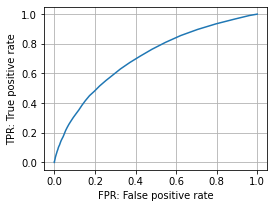

特徴量：20個の場合
AUC値:0.714929255034986


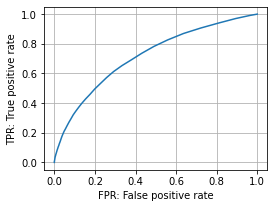

特徴量：30個の場合
AUC値:0.7110551653990786


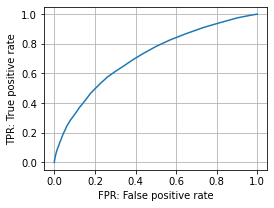

In [106]:
for i in range(1, 4):
    features = list(forest_domain_feature_importances.tail(i*10).index)
    # データ分割
    X_train_train, X_train_test, y_train_train, y_train_test = train_test_split(df_train_domain.loc[:, features], y_train, random_state=0)
    #　欠損値は中央値で埋める　　Median imputation of missing values
    imputer = SimpleImputer(strategy = 'median')
    # 0-1の間の数値に変換　　Scale each feature to 0-1
    scaler = MinMaxScaler(feature_range = (0, 1))
    # Fit on the training data
    imputer.fit(X_train_train)
    # Transform both training and testing data
    train = imputer.transform(X_train_train)
    test = imputer.transform(X_train_test)
    # Repeat with the scaler
    scaler.fit(train)
    train = scaler.transform(train)
    test = scaler.transform(test)
    from sklearn.ensemble import RandomForestClassifier
    # Make the model with the specified regularization parameter
    forest = RandomForestClassifier(n_estimators=100, random_state=50)
    # Train on the training data
    forest.fit(train, y_train_train)
    # Make predictions
    # Make sure to select the second column only
    forest_pred = forest.predict_proba(test)[:, 1]
    #　評価
    print('特徴量：{}個の場合'.format(i*10))
    roc_evaluation(y_train_test, forest_pred)

##### feature_importances
- 考察
    - 特徴量の重要度が高いもののみ抽出してもスコアが改善しなかった
    - 特徴量の取捨選択について、手法や見方は今後学習課題となると思われる